In [1]:
# nobody knows anything
#                  -Kai
#
# github.com/kaibrooks

In [2]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.layers import Dropout # dropout crew 4 lyf
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import random
import sys
import io
import os
import matplotlib.pyplot as plt # fancy plots
from datetime import datetime # so we know how much time we've wasted

print('TensorFlow version', tf.__version__)
print('Keras version', keras.__version__)
#print('SciPy version', scipy.__version__)
print('Numpy version', np.__version__) 
#print('Pillow version', PIL.__version__) 

Using TensorFlow backend.


TensorFlow version 2.0.0
Keras version 2.2.4-tf
Numpy version 1.17.4


In [3]:
# doin thangs
epochs=60 #60
epochOutput = False
temperature = [0.2, 0.5, 1.0, 1.2]


np.seterr(divide='ignore') # ignore divide by zero warnings

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
## get text file and parse it

#path = get_file( # use this for http request
#    'afile.txt',
#    origin='http://omega.lul/afile.txt')

path = 'data/lotr1.txt'

print('Loaded',path)

# print sweet ~data~ about the file
with open(path, encoding='utf-8', errors='ignore') as f: # errors=ignore strips non utf-8 chars
    text = f.read().lower()

chars = sorted(list(set(text)))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

print('corpus length :', len(text))
print('unique chars  :', len(chars))
print('total patterns:', len(sentences))
print('') # empty line

print('Vectorizing...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('Done')

Loaded data/lotr1.txt
corpus length : 969555
unique chars  : 53
total patterns: 323172

Vectorizing...
Done


In [5]:
## model
# this has NO TEST DATASET

print('Building model...')
#model = Sequential()
#model.add(LSTM(128, input_shape=(maxlen, len(chars))))
#model.add(Dense(len(chars), activation='softmax'))
#optimizer = RMSprop(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model = Sequential()
model.add(LSTM(256, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Done')

Building model...
Done


In [6]:
# train me
now = datetime.now()
print("Starting training at", now.strftime("%d-%b-%Y %H:%M:%S"), 'UTC') # lets see how long this takes

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, _):
    if epochOutput:
        # print text at each epoch
        print()
        print('**************************** Generating text after Epoch: %d ****************************' % epoch)

        start_index = random.randint(0, len(text) - maxlen - 1)
        for temperature in [temperature]:
            print('--------------- temperaturediversity: ', temperature, '---------------')

            generated = ''
            sentence = text[start_index: start_index + maxlen]
            generated += sentence
            print('--------------- seed: <', sentence,'>')
            sys.stdout.write(generated)

            for i in range(400):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, temperaturediversity)
                next_char = indices_char[next_index]

                sentence = sentence[1:] + next_char
                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)

history = model.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback])

then = datetime.now()
print("Finished training at", then.strftime("%d-%b-%Y %H:%M:%S")) # lets see how long this took

print('Model summary:')
model.summary()

Starting training at 07-Dec-2019 07:43:22 UTC
Epoch 1/60
323172/323172 [==============================] - 490s 2ms/step - loss: 2.1652 - accuracy: 0.3807
Epoch 2/60
323172/323172 [==============================] - 460s 1ms/step - loss: 1.7340 - accuracy: 0.4849
Epoch 3/60
323172/323172 [==============================] - 453s 1ms/step - loss: 1.5738 - accuracy: 0.5270
Epoch 4/60
323172/323172 [==============================] - 454s 1ms/step - loss: 1.4784 - accuracy: 0.5531
Epoch 5/60
323172/323172 [==============================] - 453s 1ms/step - loss: 1.4111 - accuracy: 0.5713
Epoch 6/60
323172/323172 [==============================] - 452s 1ms/step - loss: 1.3601 - accuracy: 0.5840
Epoch 7/60
323172/323172 [==============================] - 452s 1ms/step - loss: 1.3214 - accuracy: 0.5958
Epoch 8/60
323172/323172 [==============================] - 454s 1ms/step - loss: 1.2845 - accuracy: 0.6050
Epoch 9/60
323172/323172 [==============================] - 452s 1ms/step - loss: 1.2545 -

In [7]:
## save model log
# this is where you pay attention to where you mapped the Docker dir to your local dir at run

save_dir = os.path.join(os.getcwd(), 'trained_models')


if not os.path.isdir(save_dir): # make dir if it doesn't exist
    os.makedirs(save_dir)    
    print(save_dir, 'doesn\'t exist, creating it')

print('Saving...') # do this because saving the model takes 5+ seconds sometimes

# 
model_name = now.strftime("%Y-%m-%d_%H-%M-%S") + '_trainedmodel.h5'
summary_name = now.strftime("%Y-%m-%d_%H-%M-%S") + '_modelsummary.txt'

# save summary
with open(os.path.join(save_dir, summary_name),'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

# save model
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

#model_path = os.path.join(save_dir, summary_name)
#print(model_path)
#model.save(model_path)
  
print('Saved trained model at %s ' % os.path.join(save_dir, model_name)) 
print('Saved training summary at %s' % os.path.join(save_dir, summary_name))   

size = os.path.getsize(model_path) # note how big the model is because they're often huge
print('Model is',round(size/1e+6),'MB')

Saving...
Saved trained model at /tf/notebooks/trained_models/2019-12-07_07-43-22_trainedmodel.h5 
Saved training summary at /tf/notebooks/trained_models/2019-12-07_07-43-22_modelsummary.txt
Model is 4 MB


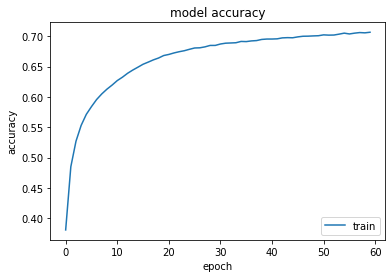

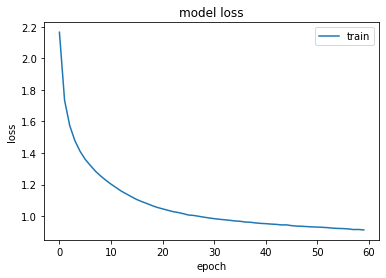

In [8]:
## plot accuracy
plt.plot(history.history['accuracy']) # kx or similar Matlab commands for plotting
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# plot history
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [15]:
## set for the final output
start_index = random.randint(0, len(text) - maxlen - 1)
sentence = text[start_index: start_index + maxlen]
randomizeOut = False
temperaturediversity = 1.0 # 0.5? depends on training length
maxChars = 10000 # 400 is same as above

if randomizeOut:
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence

seed = sentence.replace('\n','')
seed = seed.replace('\t','')
print('*** seed: <', seed ,'>')
#sys.stdout.write(generated)

print('\n',seed, end = '')

for i in range(maxChars):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds, temperaturediversity)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

*** seed: < asts. elves or men, and all kindly creat >

 asts. elves or men, and all kindly creature in disaring,' cried sam a small like now and sighed. all came out of the black stars and his stone and drowned, some, sam, and the bendlon could sudden all the gleams of the lands from his arm on the tree.
    madil had the stone above their good. for it was the north _for eventhat beyond the brief was speing, suddenly, hundrain in the rush blushed on their graves, if it was the gloom were green their, when it are disappeared. finuin he have forget the halt. poor elling many piles, the company nawed a side of the look at gildor and old the willd. he has weary. the cracks walk of elrond, made worked you any more of you, master of look, and wooded worss down a hall. for his harping passes, and come at the company falls bring, his kees were knocked.
     alone stimsed at the bark with his broad, a smill on the hobbits, half a few away frodo and many rather could store they seemed his like 

     `but not your long you and he cany to anything you until the lovers of dure os talf and be going to have done! that is consider. i have selrem. this eye we do not see your face where go,' said aragorn, lobting marr, wondering in the more kings, who thinks to his way before, silent for a moment through shadow laid with the least, wondering what were lock as thas line down. the road it round and once good off the cun and strange one ter things in frether again the fine night about him the flood was lighter mught but the water tage of grost no such course face white steep back or tall truth frodo began to gree. many lobt and men't taich soft, on the seats for these pippin in the water-poorsall. but he know mounts that bort ress was somelids, and flose. 'guesst balin's turn!' cried sam strider, strider hobbits and kning. 'speaks frodo would not more in the world. this was already he saw the last deams of soft mematiall; in here might be pillar. i have seonem to hear of my ajp their mi